In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from scipy.ndimage import convolve
import numpy.linalg as LA
from skimage import data, filters, color
from skimage import io
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def gaussian_filter(sigma):
  size = 2*np.ceil(3*sigma)+1
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

def generate_octave(init_level, s, sigma):
  octave = [init_level]
  k = 2**(1/s)
  kernel = gaussian_filter(k * sigma)
  for _ in range(s+2):
    next_level = convolve(octave[-1], kernel)
    octave.append(next_level)
  return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma):
  pyr = []
  for _ in range(num_octave):
    octave = generate_octave(im, s, sigma)
    pyr.append(octave)
    im = octave[-3][::2, ::2]
  return pyr

def generate_DoG_octave(gaussian_octave):
  octave = []
  for i in range(1, len(gaussian_octave)):
    octave.append(gaussian_octave[i] - gaussian_octave[i-1])
  return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
  pyr = []
  for gaussian_octave in gaussian_pyramid:
    pyr.append(generate_DoG_octave(gaussian_octave))
  return pyr

def get_candidate_keypoints(D, w=16):
  candidates = []
  D[:,:,0] = 0
  D[:,:,-1] = 0
  for i in range(w//2+1, D.shape[0]-w//2-1):
    for j in range(w//2+1, D.shape[1]-w//2-1):
      for k in range(1, D.shape[2]-1):
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
        if np.argmax(patch) == 13 or np.argmin(patch) == 13:
          candidates.append([i, j, k])
  return candidates


def localize_keypoint(D, x, y, s):
    dx = (D[y,x+1,s] - D[y,x-1,s]) / 2.0
    dy = (D[y+1,x,s] - D[y-1,x,s]) / 2.0
    ds = (D[y,x,s+1] - D[y,x,s-1]) / 2.0
    dxx = D[y,x+1,s] - 2.0 * D[y,x,s] + D[y,x-1,s]
    dxy = (D[y+1,x+1,s] - D[y+1,x-1,s] - D[y-1,x+1,s] + D[y-1,x-1,s]) / 4.0
    dxs = (D[y,x+1,s+1] - D[y,x-1,s+1] - D[y,x+1,s-1] + D[y,x-1,s-1]) / 4.0
    dyy = D[y+1,x,s] - 2.0 * D[y,x,s] + D[y-1,x,s]
    dys = (D[y+1,x,s+1] - D[y-1,x,s+1] - D[y+1,x,s-1] + D[y-1,x,s-1]) / 4.0
    dss = D[y,x,s+1] - 2.0 * D[y,x,s] + D[y,x,s-1]

    J = np.array([dx, dy, ds])
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    offset = -LA.inv(HD).dot(J)

    return offset, J, HD[:2,:2], x, y, s


def find_keypoints_for_DoG_octave(D, R_th, t_c, w, offset_th=0.5):
    candidates = get_candidate_keypoints(D, w)
    keypoints = []
    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        if np.any(np.abs(offset) > offset_th):
            continue

        contrast = D[y,x,s] + .5*J.dot(offset)
        if abs(contrast) < t_c:
            continue

        w, v = LA.eig(H)
        if np.any(w == 0):
            continue

        r = w[1]/w[0]
        R = (r+1)**2 / r
        if R > R_th:
            continue

        kp = np.array([x, y, s]) + offset
        keypoints.append(kp)

    return np.array(keypoints)


def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []
    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))
    return kps

def get_candidate_keypoints_integrate(DoG_pyr, w):
    kps = []

    for D in DoG_pyr:
        candidates = get_candidate_keypoints(D, w)
        keypoints = []
        for i, cand in enumerate(candidates):
            y, x, s = cand[0], cand[1], cand[2]
            keypoints.append(np.array([x, y, s]))
        kps.append(np.array(keypoints))
    return kps

def myDrawKeypoints(image, kps):
    fig, axs = plt.subplots(1, 1, figsize=(12, 8))
    axs.imshow(image, cmap='gray')
    h = image.shape[0]
    colors = ['red', 'green', 'blue', 'black']

    for o in range(len(kps)):
        if len(kps[o]) == 0:
            continue
        kpso = kps[o]*(2**o)
        for pt in kpso:
            axs.scatter(pt[0], pt[1], color=colors[o], alpha = 0.5)

    plt.show()

In [4]:
def assign_orientation(kps, octave, num_bins=36):
    new_kps = []

    # 히스토그램 bin 너비
    bin_width = 360 // num_bins

    for kp in kps:
        #특징점 kp에서 좌표 추출
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])

        # s가 octave 범위 내에 있도록 함.
        s = np.clip(s, 0, octave.shape[2] - 1)

        # 가우시안 필터 생성
        sigma = kp[2] * 1.5
        w = int(2 * np.ceil(sigma) + 1)
        kernel = gaussian_filter(sigma)

        # 키포인트의 스케일에 해당하는 옥타브 이미지의 2D 슬라이스 L을 선택합니다.
        L = octave[:, :, s]

        hist = np.zeros(num_bins, dtype=np.float32)

        #5. 가우시안 윈도우 내부의 각 픽셀에 대해 연산
        for oy in range(-w, w + 1):
            for ox in range(-w, w + 1):
                #픽셀의 좌표 x, y 계산
                x, y = cx + ox, cy + oy

                #픽셀이 이미지 범위 내에 있는지 확인
                if x < 0 or x >= octave.shape[1] or y < 0 or y >= octave.shape[0]:
                    continue

                # gradient 및 방향 계산
                m, theta = get_grad(L, x, y)

                # 가중치 계산
                weight = kernel[oy + w, ox + w] * m

                # 방향 양자화
                bin = quantize_orientation(theta, num_bins)

                # 히스토그램에 추가
                hist[bin] += weight

        # 히스토그램에서 최대값을 찾고, 키포인트 추가
        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        #7. 7. 히스토그램의 다른 빈들을 순회하면서, 최대값의 80% 이상인 빈에 대해서도 키포인트를 new_kps에 추가합니다.

        # 이는 한 키포인트가 여러 개의 우세한 방향을 가질 수 있음을 고려한 것입니다.
        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin:
                continue
            if 0.8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

def fit_parabola(hist, binno, bin_width):

    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.

    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])

    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)],
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]

    if x[0] == 0: x[0] = 1e-6

    return -x[1]/(2*x[0])

def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi

    return m, theta

def get_grad(L, x, y):

    #min과 max 함수는 이미지의 경계를 넘어서는 인덱스 접근을 방지하기 위해 사용
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]

    return cart_to_polar_grad(dx, dy)

def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins

    #내림 연산 수행 np.floor & quntization
    return int(np.floor(theta)//bin_width)

def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):

    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
        L = octave[:, :, s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]
        dx, dy = get_patch_grads(patch)

        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]

        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[:, kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:, :dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]

        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[:, kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:, :dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), theta[t:b, l:r].ravel(), num_bin, kp[3], bin_width, subregion_w)

                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        #featvet은 numpy 즉 float32이므로 float으로 형 변환해야함.
        #벡터의 크기 정규화(각 요소를 벡터의 크기로 나누어 정규화)
        featvec /= max(1e-6, float(LA.norm(featvec)))

        #불리언 인덱싱으로 거르기
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, float(LA.norm(featvec)))

        descs.append(featvec)

    return np.array(descs)

def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]
    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):

    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle - reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        #픽셀의 좌표를 계산(np.unravel_index)
        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))

        x_interp_weight = max(1 - abs(gx - c) / c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c) / c, 1e-6)

        #픽셀이 서브리전의 중심에서 얼마나 떨어져 있는지에 따라 x와 y 방향의 가중치를 계산

        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    hist /= max(1e-6, float(LA.norm(hist)))

    #히스토그램의 각 요소가 0.2를 넘지 않도록 클리핑. 이는 밝은 영역에서 특징이 과도하게 강조되는 것을 방지하기 위함임.
    hist[hist>0.2] = 0.2

    hist /= max(1e-6, float(LA.norm(hist)))
    return hist

class SIFT(object):
    def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):

        if len(im.shape) == 3:
            self.im = convolve(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0, gaussian_filter(s0))
        else:
            self.im = convolve(im.astype(np.float64) / 255.0, gaussian_filter(s0))  # Normalize grayscale image

        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.t_c = t_c
        self.R_th = (r_th+1)**2 / r_th
        self.w = w

    def get_features(self):

        gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
        kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
        feats = []

        for i, DoG_octave in enumerate(DoG_pyr):
            kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
            feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

        self.kp_pyr = kp_pyr
        self.feats = feats

        return feats

In [5]:
def get_features(fnames):
    ims = []

    kp_feats = []
    kp_ptrs = []

    for i, fname in enumerate(fnames):
        im = cv2.imread(fname)
        ims.append(im)
        gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        sift_detector = SIFT(gray_image)
        _ = sift_detector.get_features()

        feats = sift_detector.feats
        pyrs = sift_detector.kp_pyr

        featsAcc = []  # Use a list to accumulate features
        ptrsAcc = []   # Use a list to accumulate keypoints

        for oct_i, oct_v in enumerate(pyrs):
            kps = oct_v * (2 ** oct_i)

            if feats[oct_i].size > 0:
                featsAcc.append(feats[oct_i])
                ptrsAcc.append(kps)

        if featsAcc:  # Only append if featsAcc is not empty
            kp_feats.append(np.vstack(featsAcc))
            kp_ptrs.append(np.vstack(ptrsAcc))

    return ims, kp_ptrs, kp_feats

def get_matches(feats1, feats2, ratio=0.8):
    idxs1, idxs2 = [], []
    for i, feat in enumerate(feats1):
        distances = LA.norm(feats2 - feat, axis=1)
        nn = np.argsort(distances)[:2]
        dist1, dist2 = distances[nn[0]], distances[nn[1]]

        if dist1/max(1e-6, dist2)  < ratio:
            idxs1.append(i)
            idxs2.append(nn[0])

    return idxs1, idxs2

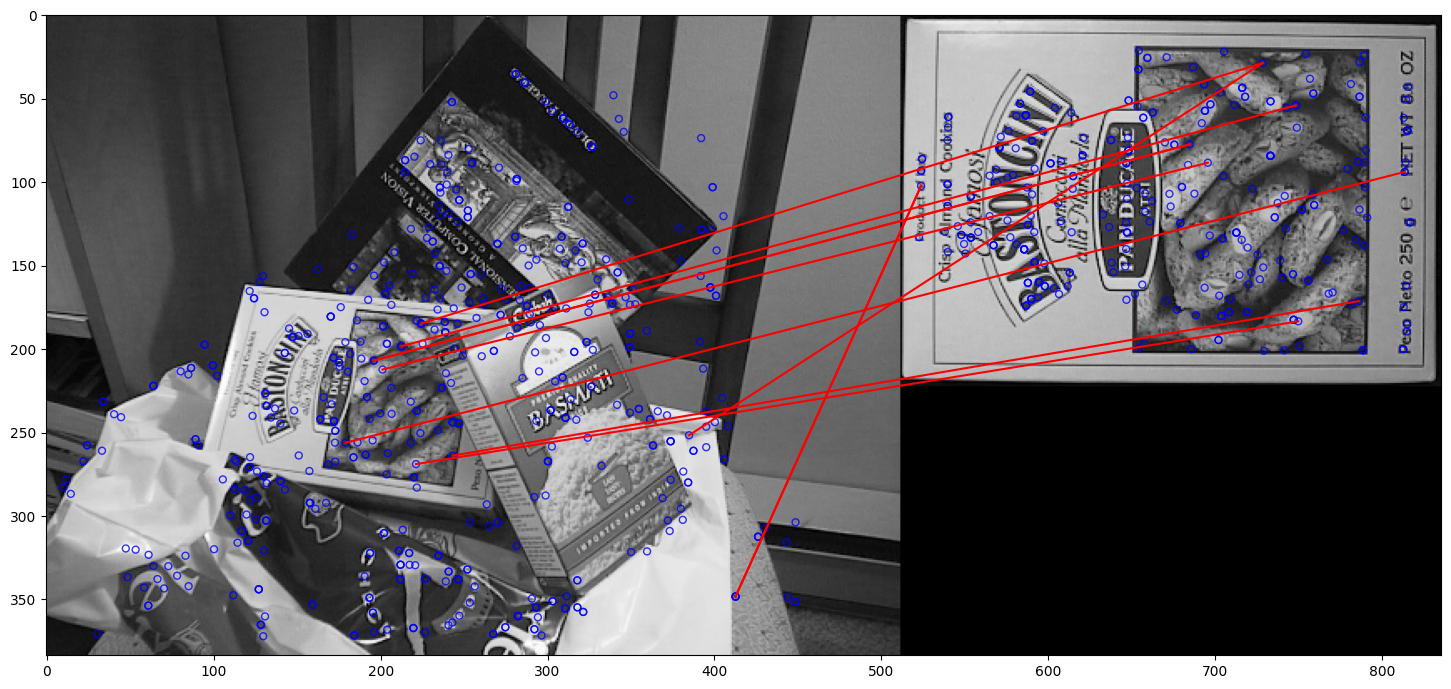

In [7]:
fnames = ['/content/drive/MyDrive/Image/box_in_scene.png', '/content/drive/MyDrive/Image/box.png']

ims, kp_ptrs, kp_feats = get_features(fnames)
idxs1, idxs2 = get_matches(kp_feats[0], kp_feats[1])

row1, col1 = ims[0].shape[:2]
row2, col2 = ims[1].shape[:2]

stackedImage = np.zeros((max(row1, row2), col1+col2, ims[0].shape[2]),dtype=ims[0][0, 0, 0].dtype)

stackedImage[:row1, :col1, :] = ims[0]
stackedImage[:row2, col1: col1 + col2, :] = ims[1]

_, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.imshow(stackedImage)
ax.scatter(kp_ptrs[0][:, 0], kp_ptrs[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
ax.scatter(kp_ptrs[1][:, 0] + col1, kp_ptrs[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs1)):
    kps1 = kp_ptrs[0][idxs1[i]]
    kp2s = kp_ptrs[1][idxs2[i]]
    x1, y1 = (kps1[0], kps1[1])
    x2, y2 = (kp2s[0] + col1, kp2s[1])
    ax.plot([x1, x2], [y1, y2], 'r')


plt.show()

In [11]:
def stack_images(im1, im2):
    im1_size = im1.shape[:2]
    im2_size = im2.shape[:2]
    stacked_image = np.zeros((max(im1_size[0], im2_size[0]), im1_size[1] + im2_size[1], im1.shape[2]),
                             dtype=im1.dtype)
    stacked_image[:im1_size[0], :im1_size[1], :] = im1
    stacked_image[:im2_size[0], im1_size[1]:im1_size[1] + im2_size[1], :] = im2
    return stacked_image

fnames = ['/content/drive/MyDrive/Image/box_in_scene.png', '/content/drive/MyDrive/Image/box.png']

# 첫 번째 이미지 세트의 특징 및 매칭
feat_first = get_features(fnames)
feat_first_ratio = 0.8
idxs_first = get_matches(feat_first[2][0], feat_first[2][1], feat_first_ratio)

# 두 번째 이미지 세트의 특징 및 매칭
feat_second = get_features(fnames)
feat_second_ratio = 0.9
idxs_second = get_matches(feat_second[2][0], feat_second[2][1], feat_second_ratio)

# 이미지 스태킹
stacked_first_image = stack_images(feat_first[0][0], feat_first[0][1])
stacked_second_image = stack_images(feat_second[0][0], feat_second[0][1])

# 서브플롯 설정
fig, axs = plt.subplots(2, 1, figsize=(18, 24))

# 첫 번째 이미지 세트의 매칭 시각화
axs[0].imshow(stacked_first_image)
axs[0].set_title(f'Descriptor Matching (ratio = {feat_first_ratio})')
col1_first = feat_first[0][0].shape[1]
kp_ptrs_first = feat_first[1]

axs[0].scatter(kp_ptrs_first[0][:, 0], kp_ptrs_first[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
axs[0].scatter(kp_ptrs_first[1][:, 0] + col1_first, kp_ptrs_first[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs_first[0])):
    kps1 = kp_ptrs_first[0][idxs_first[0][i]]
    kps2 = kp_ptrs_first[1][idxs_first[1][i]]
    x1, y1 = kps1[0], kps1[1]
    x2, y2 = kps2[0] + col1_first, kps2[1]
    axs[0].plot([x1, x2], [y1, y2], 'r')

# 두 번째 이미지 세트의 매칭 시각화
axs[1].imshow(stacked_second_image)
axs[1].set_title(f'Descriptor Matching (ratio = {feat_second_ratio})')
col1_second = feat_second[0][0].shape[1]
kp_ptrs_second = feat_second[1]

axs[1].scatter(kp_ptrs_second[0][:, 0], kp_ptrs_second[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
axs[1].scatter(kp_ptrs_second[1][:, 0] + col1_second, kp_ptrs_second[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs_second[0])):
    kps1 = kp_ptrs_second[0][idxs_second[0][i]]
    kps2 = kp_ptrs_second[1][idxs_second[1][i]]
    x1, y1 = kps1[0], kps1[1]
    x2, y2 = kps2[0] + col1_second, kps2[1]
    axs[1].plot([x1, x2], [y1, y2], 'r')

plt.show()

Output hidden; open in https://colab.research.google.com to view.